In [128]:
#imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score, accuracy_score

import numpy as np
import os, shutil

from collections import defaultdict

import torch.nn.functional as F

In [162]:
# Define CNN architecture classes
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class DeepCNN(nn.Module):
    def __init__(self):
        super(DeepCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 4 * 4, 256) #old, replaced below
        self.prelu = nn.PReLU() 
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.prelu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

In [164]:
#pytorch configs
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
num_epochs = 2 #50 #how many of training cycles to run?
batch_size = 500 #how many records at one time?
learning_rate = 0.005 # how fast can you learn? size of the learning step? 0.01 was the best last time
iter_save = 10 #100

# lambda function
transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    #transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [166]:
# Functions

#Training the model
def train_model(model, train_loader):
    global loader_map
    results = { loader_name: defaultdict(list) for loader_name in loader_map }
    
    model.train()
    
    running_loss = 0.0
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            #labels are the actual values of the images
            images, labels = images.to(device), labels.to(device)
            # Forward pass
            #outputs are the logits of the predicted values of the images 
            outputs = model(images)
            loss = criterion(outputs, labels)
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if (i+1)%iter_save == 0:
                #train_f1, train_acc, train_loss = test_model(model, train_loader)
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss/iter_save:.4f}")
                running_loss = 0.0

                for loader_name in loader_map:
                    f1, acc, loss = test_model(model, loader_map[loader_name])
                    results[loader_name]['f1'].append(f1)
                    results[loader_name]['acc'].append(acc)
                    results[loader_name]['loss'].append(loss)
                    
    #print(results)
    return results

# Testing the model
def test_model(model, data_loader):
    pred = []
    act = []
    running_loss = 0.0
    model.eval()
    with torch.no_grad():
        for images, labels in data_loader: 
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, pred_class = torch.max(outputs.data, 1)
            
            pred.append(pred_class)
            act.append(labels)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)

        pred = np.concatenate(pred)
        act = np.concatenate(act)
        # f1 scores
        f1 = f1_score(act, pred, average='weighted')
        # accuracies
        acc = accuracy_score(act, pred, normalize=True)
        # loss
        loss = running_loss/len(data_loader.dataset)
            
    return f1, acc, loss

#plot performance of the models against all datasets in the global data loader map
def plotPerformance(metric, lr, iter):
    loader_name_list = []
    max_len = max([len(results[loader][metric]) for loader in results])
    x_list = np.arange(iter, iter*(max_len+1), iter)
    for loader in results:
        y_list = results[loader][metric]
        loader_name_list.append(loader)
        plt.plot(x_list, y_list)
    plt.legend(loader_name_list, loc="lower right", bbox_to_anchor=(1.0, 1.05))
    plt.xlabel('iterations')
    plt.ylabel(f'{metric} scores')
    plt.xticks(x_list, rotation=90)
    plt.title(f'{metric} vs iterations for learning rate {lr}')
    plt.show() 


def save_model(model, rel_file_path):
    #example: "model/CIFAR_real_deepNN.pth")
    torch.save(model, rel_file_path)

def get_model(rel_file_path):
   #Load the saved model
    model = torch.load(rel_file_path, weights_only=False)
    model.eval()
    return model

#move files into directories with labels (used for CIFAKE)
def moveFiles(dir_path):
    #Call syntax: moveFiles("data/archive/train/FAKE/")
    dir = os.fsdecode(dir_path)
    if not os.path.isdir(dir_path):
        print("is not directory. sad!")
        return

    #creating new number directories
    for i in range(1, 11):
        dst = os.path.join(dir_path, str(i))
        os.mkdir(dst)
        
    #for labels 2 to 10
    for file in os.listdir(dir):
        file_src = os.fsdecode(file)
        for i in range(2, 11):
            if file_src.endswith(f"({i}).jpg"):
                src = os.path.join(dir_path, file_src)
                dst = os.path.join(dir_path, str(i))
                shutil.move(src, dst)
                
    #for label 1
    for file in os.listdir(dir):
        file_src = os.fsdecode(file)
        if file_src.endswith(".jpg"):
            src = os.path.join(dir_path, file_src)
            dst = os.path.join(dir_path, "1")
            shutil.move(src, dst)

def addLoader(loader_name, dir, format):
    global loader_map
    is_train = "train" in loader_name
    if format == "CIFAKE":
        dataset = torchvision.datasets.ImageFolder(root=dir, transform=transform)
        loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=is_train)
        moveFiles(dir)
        
    elif format == "CIFAR":
        dataset = torchvision.datasets.CIFAR10(root=dir, train=is_train, download=True, transform=transform)
        loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=is_train)
        
    loader_map[loader_name] = loader

In [95]:
##data loads - TRY THIS NEXT TIME INSTEAD OF NEXT CELL - DOES NOT WORK, NEED TO DEBUG
#loadermap = {}
##addLoader(train_loader, './data', "CIFAR")
##addLoader(test_loader, './data', "CIFAR")
##addLoader(fake_train_loader, './data/archive/train/FAKE', "CIFAKE")
##addLoader(fake_test_loader, './data/archive/test/FAKE', "CIFAKE")
#addLoader("real_train_loader", './data/archive/train/REAL', "CIFAKE")
#addLoader("real_test_loader", './data/archive/test/REAL', "CIFAKE")

In [168]:
#data loads
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
fk_test_dataset = torchvision.datasets.ImageFolder(root='./data/archive/test/FAKE', transform=transform)
fk_train_dataset = torchvision.datasets.ImageFolder(root='./data/archive/train/FAKE', transform=transform)
rl_train_dataset = torchvision.datasets.ImageFolder(root='./data/archive/train/REAL', transform=transform)
rl_test_dataset = torchvision.datasets.ImageFolder(root='./data/archive/test/REAL', transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
fake_test_loader = torch.utils.data.DataLoader(dataset=fk_test_dataset, batch_size=batch_size, shuffle=True)
fake_train_loader = torch.utils.data.DataLoader(dataset=fk_train_dataset, batch_size=batch_size, shuffle=True)
real_train_loader = torch.utils.data.DataLoader(dataset=rl_train_dataset, batch_size=batch_size, shuffle=True)
real_test_loader = torch.utils.data.DataLoader(dataset=rl_test_dataset, batch_size=batch_size, shuffle=True)

# define global map of loader_name to data loaders
loader_map = {
    #"CIFAR_test": test_loader,
    #"CIFAR_train": train_loader,
    #"CIFAKE_fake_test": fake_test_loader,
    #"CIFAKE_fake_train": fake_train_loader,
    "CIFAKE_real_test": real_test_loader,
    "CIFAKE_real_train": real_train_loader
}

Files already downloaded and verified
Files already downloaded and verified


In [170]:
# Select the model
#model = SimpleCNN().to(device)
model = DeepCNN().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adagrad(model.parameters(), lr=learning_rate)

results = train_model(model, real_train_loader)

Epoch [1/2], Step [10/100], Loss: 2.2956
Epoch [1/2], Step [20/100], Loss: 2.2624
Epoch [1/2], Step [30/100], Loss: 2.2323
Epoch [1/2], Step [40/100], Loss: 2.1822
Epoch [1/2], Step [50/100], Loss: 2.1706
Epoch [1/2], Step [60/100], Loss: 2.1379
Epoch [1/2], Step [70/100], Loss: 2.1220
Epoch [1/2], Step [80/100], Loss: 2.1038
Epoch [1/2], Step [90/100], Loss: 2.0944
Epoch [1/2], Step [100/100], Loss: 2.0797
Epoch [2/2], Step [10/100], Loss: 2.0794
Epoch [2/2], Step [20/100], Loss: 2.0741
Epoch [2/2], Step [30/100], Loss: 2.0589
Epoch [2/2], Step [40/100], Loss: 2.0484
Epoch [2/2], Step [50/100], Loss: 2.0428
Epoch [2/2], Step [60/100], Loss: 2.0460
Epoch [2/2], Step [70/100], Loss: 2.0304
Epoch [2/2], Step [80/100], Loss: 2.0211
Epoch [2/2], Step [90/100], Loss: 2.0176
Epoch [2/2], Step [100/100], Loss: 2.0308


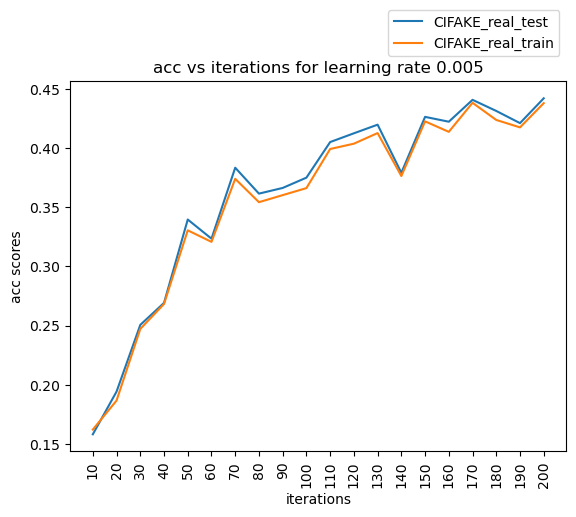

In [172]:
#LR 0.005 - adagrad optimizer with 2 epochs and PRELU
plotPerformance('acc', learning_rate, iter_save)

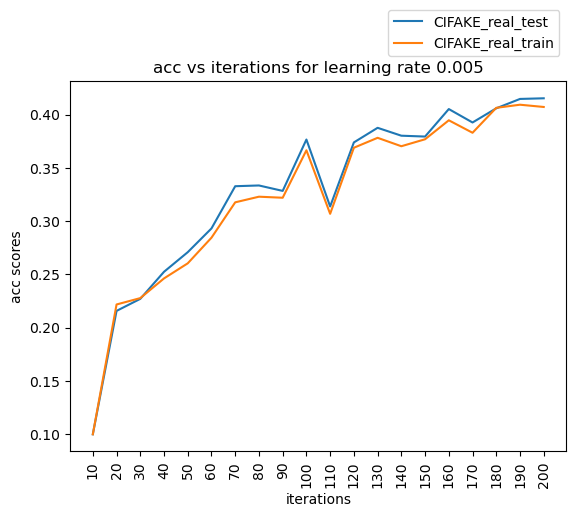

In [140]:
#LR 0.005 - adagrad optimizer with 2 epochs
plotPerformance('acc', learning_rate, iter_save)

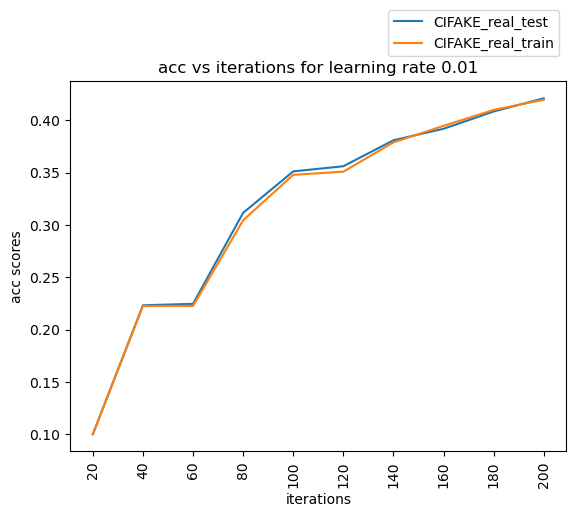

In [67]:
#LR 0.01 - adagrad optimizer another round 2 epochs
plotPerformance('acc', learning_rate, iter_save)

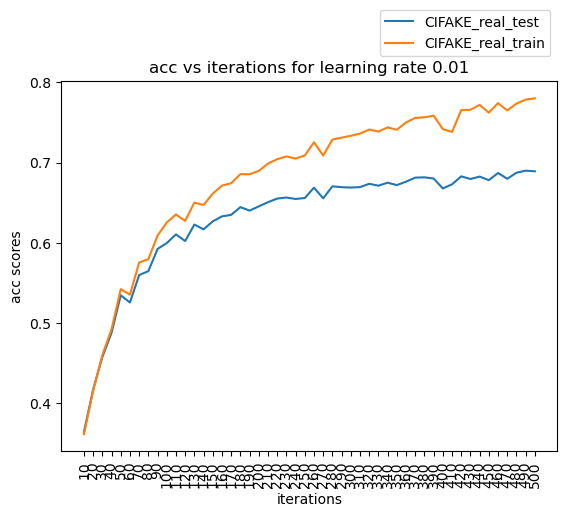

In [126]:
#LR 0.01 - adagrad optimizer with 50 EPOCHS and saving every epoch
plotPerformance('acc', learning_rate, iter_save)

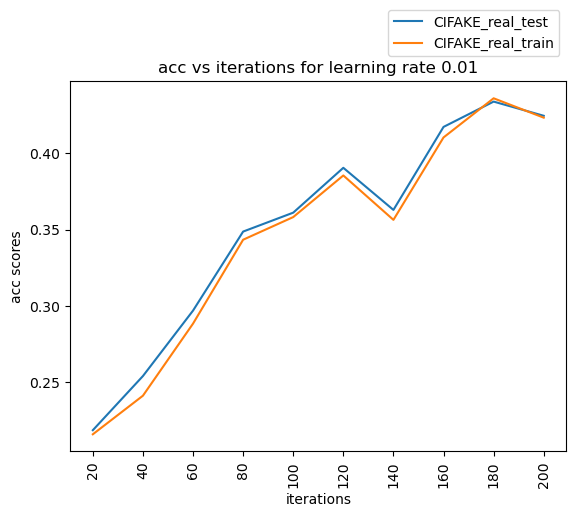

In [59]:
#LR 0.01 - adamax optimizer 
plotPerformance('acc', learning_rate, iter_save)

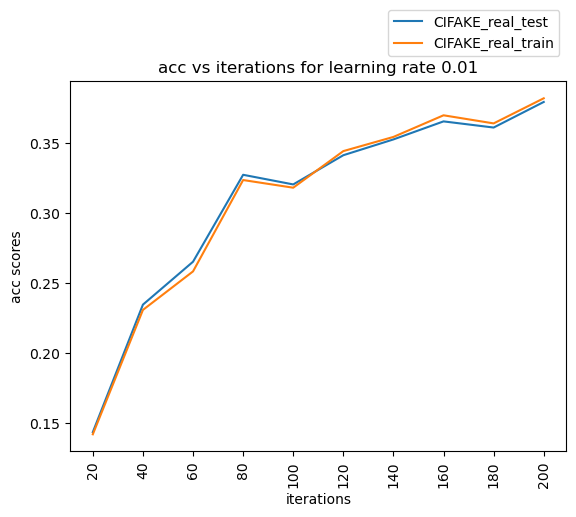

In [55]:
#LR 0.01 - adam optimizer (tried adadelta: does not learn)
plotPerformance('acc', learning_rate, iter_save)

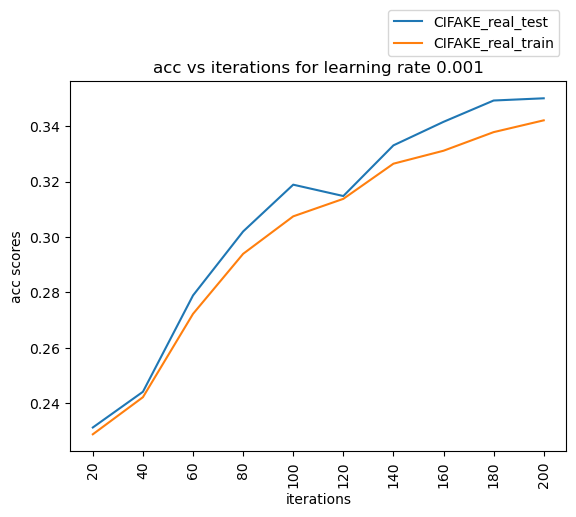

In [35]:
#LR 0.001; Adagrad
plotPerformance('acc', learning_rate, iter_save)

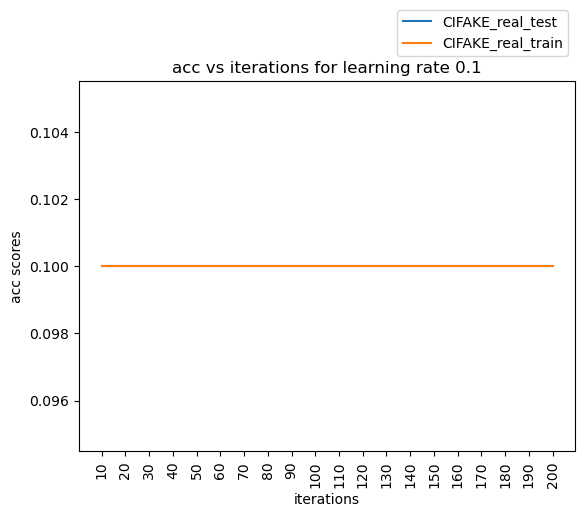

In [25]:
#LR 0.1; adagrad
plotPerformance('acc', learning_rate, iter_save)

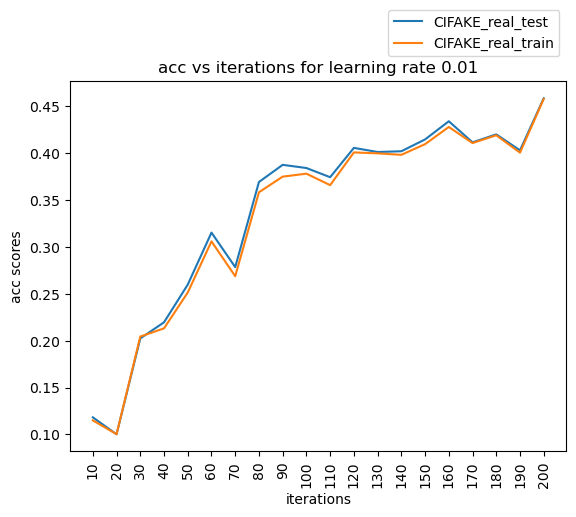

In [275]:
#LR 0.01; Adagrad optimizer
plotPerformance('acc', learning_rate, iter_save)